핸즈온 3장 분류 p.127-154

---

# 3. 분류

## 3.1 MNIST

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- DESCR 키 : 데이터 셋 설명
- data 키 : 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가짐.
- target 키 : 레이블 배열을 담음.

In [2]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

- 이미지 70000개
- 784개의 특성 -> 28x28 픽셀
- 개개의 특성 : 픽셀의 강도 -> 0(흰색)~255(검은색)

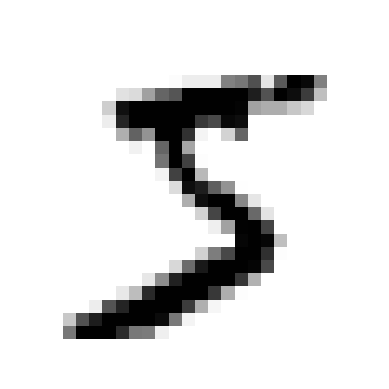

In [4]:
# 맷플롯립의 imshow()함수 사용

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

some_digit = X[0]
some_digit_image= np.array(some_digit).reshape(28,28)

plt.imshow(some_digit_image,cmap="binary")
plt.axis("off")
plt.show()

In [5]:
# 실제 레이블 확인
y[0]

'5'

In [6]:
# 레이블은 문자열이기 때문에 정수로 변환
y = y.astype(np.uint8)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

데이터를 자세히 조사하기 전에 항상 테스트 세트를 만들고 따로 떼어놓아야 한다.
- MNIST 데이터셋은 이미 훈련 세트(앞쪽 60,000개의 의미지)와 테스트 세트(뒤쪽 10,000개의 이미지)로 나누어 놓음
- 훈련 세트는 이미 섞여 있어서 모든 교차 검증 폴드를 비슷하게 만든다. 어떤 학습 알고리즘은 훈련 샘플의 순서에 민감해서 많은 비슷한 샘플이 연이어 나타나면 성능이 나빠진다.

-> 데이터셋을 섞으면 성능 저하를 방지할 수 있다.

---
## 3.2 이진 분류기 훈련

이진 분류기 : 두개의 클래스 구분

In [8]:
y_train_5 = (y_train ==5) # 5는 True이고, 다른 숫자는 모두 False
y_test_5 = (y_test ==5)

SGDClasifier 클래스 이용 -> 확률적 경사 하강법

확률적 경사 하강법(SGD) 분류기
- 매우 큰 데이터셋을 효율적으로 처리
- 한 번에 하나씩 훈련 샘플을 독립적으로 처리

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

- SGBClassifier는 훈련하는 데 무작위성 사용
- 결과를 재현하려면 random_state 매개변수 지정 필요

In [10]:
# 모델을 이용하여 5의 이미지 감지
sgd_clf.predict([some_digit])

array([ True])

---
## 3.3 성능 측정

### 3.3.1 교차 검증을 사용한 정확도 검증

In [13]:
# 사이킷런의 cross_cal_score() 사용

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3) #, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))  # 0.9669, 0.91625, 0.96785 출력

0.95035
0.96035
0.9604


StratifiedKFold
- 클래스별 비율이 유지되도록 폴드르 만들기 위해 계층적 샘플리 수행
- 매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측을 만든다 -> 올바른 예측의 수를 세어 정확한 예측 비율 출력


k-겹 교차 검증
- 훈련 세트를 k개(여기서는 3개)의 폴드로 나누고, 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용

In [15]:
# cross_val_score() 함수로 폴드가 3개인 k-겹 교차 검증을 사용해 SGDClassifier 모델 평가
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train,y_train_5, cv=3 , scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

- 정확도가 95% 이상이다.

In [14]:
# 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기를 만들어 비교
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self,X,y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X),1), dtype= bool)

In [16]:
# 모델 정확도 추측
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

- 정확도가 90% 이상

-> 정확도를 분류기의 성능 지표로 선호하지 않는 이유를 보여준다. (특히 불균형한 데이터셋을 다룰 때)

### 3.3.2 오차 행렬

- 기본적인 아이디어 : 클래스 A의 샘프리 클래스 B로 분류된 횟수를 세는 것
- 오차행렬을 만들려면 먼저 예측 값을 만들어야 한다. (테스트 세트로 한 예측은 여기서 사용 x)

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cross_val_predict() 함수
- k-겹 교차 검증 수행
- 평가 점수 반환 x
- 각 테스트 폴드에서 얻은 예측을 반환

-> 훈련 세트의 모든 샘플에 대해 깨끗한 예측을 얻게 된다.

In [18]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

오차 행렬
- 행 : **실제 클래스**
- 열 : **예측한 클래스**

In [19]:
y_train_perfect_predictions = y_train_5  # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

**정밀도**
- 양성 예측의 정확도
- $\displaystyle 정밀도 = \frac{TP}{
\displaystyle TP+\displaystyle FP }$
- TP : 양성의 수
- FP : 거짓 야성의 수

**재현율 ( = 민감도)**
- 분류기가 정확하게 감지한 양성 샘플의 비율
- $\displaystyle 재현율 = \frac{TP}{
\displaystyle TP+\displaystyle FN }$
- FN : 거짓 음성의 수

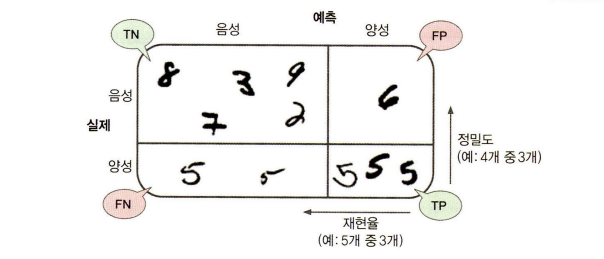

### 3.3.3 정밀도와 재현율

사이킷런은 정밀도와 재현율을 포함하여 분류기의 지표를 계산하는 여러 함수 제공

In [21]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522)

0.8370879772350012

In [22]:
recall_score(y_train_5, y_train_pred) # == 4096 / ( 4096 + 1325 )

0.6511713705958311

**F1 점수**
- 정밀도와 재현율의 조화 평균
- $\displaystyle F1 = \frac{2}{
\displaystyle \frac{1}{
\displaystyle 정밀도}+ \frac{1}{
\displaystyle 재현율} }= 2 *  \frac{정밀도*재현율}{
\displaystyle 정밀도+재현율} = \frac{TP}{ TP +
\frac{FN+FP}{
\displaystyle 2} }$

In [23]:
# f1_score() 함수 호출 -> f1 점수 계산
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

- 정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높다.
- 하지만 항상 바람직한 것은 아니다.
- 상황에 따라 정밀도가 중요할 수도 있고 재현율이 중요할 수도 있다.

정밀도를 올리면 재현율이 줄고 그 반대도 마찬가지이다.

-> 정밀도/재현율 트레이드오프

### 3.3.4 정밀도/재현율 트레이드오프

SGCClassifier 분류기
- 결정 함수를 사용하여 각 샘플의 점수 계산
- 이 점수가 임곗값보다 크면 샘플을 양성 클래스에 할당, 그렇지 않으면 음성 클래스에 할당.


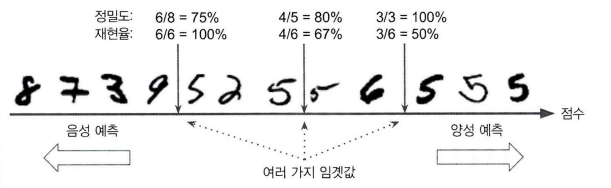

- 사이킷런에서 임곗값을 직접 지정할 수는 없지만 예측에 사용한 점수를 확인할 수 있다.
- 분류기의 predict() 메서드 대신 decision_function() 메서드를 호출하면 각 샘플의 점수를 얻을 수 있다.

In [24]:
# 각 샘플의 점수 확인
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [25]:
# 이 점수를 기반으로 원하는 임곗값을 정해 예측을 만든다
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [26]:
# 임곗값을 높이기
threshold= 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

- 임곗값을 높이면 재현율이 줄어들었다.

-> 임곗값 정하기
- cross_val_predict() 함수를 사용해 훈련 세트에 있는 모든 샘플의 점수 구하기
- 이번에는 예측 결과가 아니라 결정 점수를 반환받도록 지정

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3 ,
                             method = "decision_function")

In [28]:
# 이 점수로 가능한 모든 임계값에 대해 정밀도와 재현율 계산
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

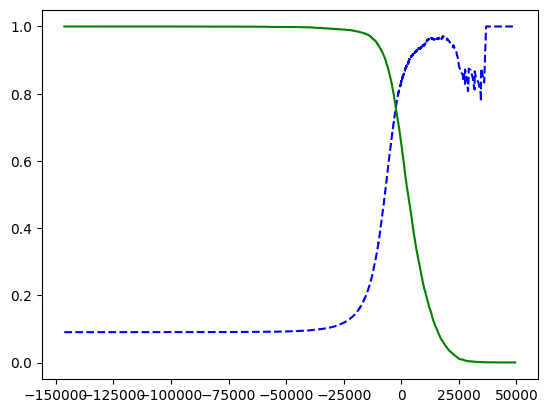

In [29]:
# 맷플롯립을 이용해 임곗값의 함수로 정밀도와 재현율 그리기
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
  plt.plot(thresholds, recalls[:-1], "g-", label="재현율")
  [...] # 임곗값을 표시하고 범례, 축 이름, 그리드를 추가합니다.

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [31]:
# 조금 더 정확하게 최소한 90% 정밀도가 되는 가장 낮은 임곗값 찾기
# np.argmax는 최댓값의 첫 번째 인덱스를 반환
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [32]:
# 훈련 세트에 대한 예측을 만들려면 predict() 메서드를 호출하는 대신 다음 코드를 실행
y_train_pred_90=(y_scores >= threshold_90_precision)

In [33]:
# 이 예측에 대한 정밀도와 재현율 확인
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


### 3.3.5 ROC 곡선

수신기 조작 특성(ROC) 곡선
- 이진 분류에 사용. 정밀도/재현율 곡선과 비슷
- 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR)의 곡선
> FPR = (1에서 진짜 음성 비율(TNR=특이도)을 뺀 값).

- 민감도에 대한 1-특이도 그래프
- ROC = (1-특이도) / 민감도(재현육)


In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

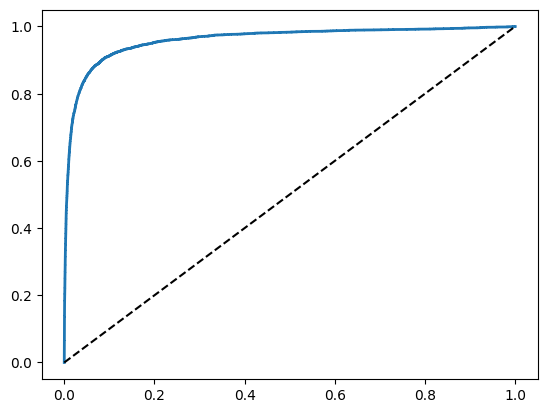

In [35]:
# 맷플롯립을 사용해 TPR에 대한 FPR 곡선 그리기
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1],[0,1],'k--')  # 대각 점선
  [...]  # 축 이름, 그리드 추가

plot_roc_curve(fpr, tpr)
plt.show()

- 트레이드오프가 있다 : 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어난다.
- 점선은 완전한 랜덤 분류기의 ROC 곡선을 뜻한다.
- 좋은 분류기는 이 점선에서 최대한 멀리 떨어져야 한다.

AUC(곡선 아래의 면적) -> 분류기 비교 가능
- 완전한 분류기 : AUC = 1
- 완전 랜덤 분류기 : AUC = 0.5

In [36]:
# AUC 계산 함수
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [37]:
# RandomForestClassifier 훈련시켜 SGDClassifier의 ROC곡선과 ROC AUC점수와 비교
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method="predict_proba")

- RandomForestClassifier에는 decision_function() 메서드가 없고 predict_proba 메서드가 있다.
- 샘플이 주어진 클래스에 속할 확률을 담은 배열 반환

In [38]:
y_scores_forest = y_probas_forest[:,1] #양성 클래스에 대한 확률을 점수로 사용합니다.
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45924 (\N{HANGUL SYLLABLE DEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

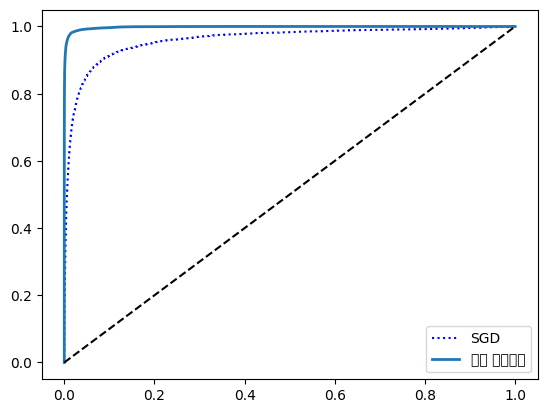

In [39]:
# 비교를 위해 첫 번째 ROC 곡선 그리기
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc="lower right")
plt.show()

- RandomForestClassifier의 ROC 곡선이 왼쪽 모서리ㅔ 더 가까워 SGDClassifier보다 훨씬 좋아 보인다.

In [40]:
# ROC AUC 점수도 훨씬 높다.
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

---
## 3.4 다중 분류

- 다중 분류기(다항 분류기): 둘 이상의 클래스 구별
- SGD 분류기, 랜덤 포레스트 분류기, 나이브 베이지 분류기 등 -> 여러 개의 클래스 직접 처리
- 로지스틱 회귀, 서포트 벡터 머신 분류기 등 -> 이진 분류만 가능
- 이진 분류기를 여러 개 사용해 다중 클래스를 분류하는 기법도 많음.
> - OvR : 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택
>- OvO : 각 숫자의 조합마다 이진 분류기를 훈련시키는 것

In [41]:
# 서포트 벡터 머신 분류기 테스트
from sklearn.svm import SVC
svm_clf= SVC()
svm_clf.fit(X_train, y_train) # y_train_5가 아니고 y_train을 사용합니다.
svm_clf.predict([some_digit])

array([5], dtype=uint8)

- 내부에서는 사이킷런이 OvO 전략을 사용해 10개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스 선택

In [42]:
# 샘플 당 10개의 점수 반환 (점수는 클래스마다 하나씩)
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([2164.22030239])

- 가장 높은 점수가 클래스 5에 해당하는 값

In [43]:
np.argmax(some_digit_scores)

0

In [44]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [45]:
# 가장 높은 점수가 클래스 5에 해당하는 값
svm_clf.classes_[5]

5

In [46]:
# SVC 기반으로 OvR 전략 사용하는 다중 분류기 만들기
from sklearn.multiclass import OneVsOneClassifier

ovr_clf = OneVsOneClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [47]:
len(ovr_clf.estimators_)

45

In [48]:
# SGDClassifier 훈련
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [49]:
# SGD 분류기가 클래스마다 부여한 점수 확인
## decision_function(): 클래스마다 하나의 값 반환
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

- 예측 결과에 강한 확신을 보이고 있음.

In [50]:
# 분류기 평가 -> 교차 검증 사용
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [51]:
# 성능을 더 높이기 위해 StandardScaler 이용해 입력 스케일 조정
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

---
## 3.5 에러 분석

모델 성능 향상의 한 가지 방법

- 오차 행렬 살피기

In [52]:
# cross_val_predict() 함수 이용해 예측 만들고, confusion_matrix() 함수 호출
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

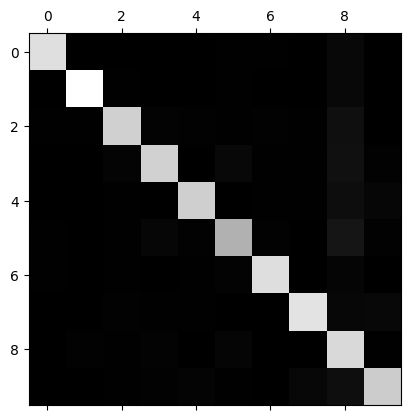

In [53]:
# 오차 행렬을 맷플롯립의 matshow() 함수 사용해 이미지로 표현 -> 보기에 편리함
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

 이 오차 행렬은 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 매우 좋아 보인다.

- 숫자 5가 다른 숫자보다 조금 더 어두워 보이는 이유: 데이터셋에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻
- 두 경우에 대해 모두 확인해 보아야 함.

그래프의 에러 부분에 초점 맞추기

In [54]:
# 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율 비교 (개수로 비교 X)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

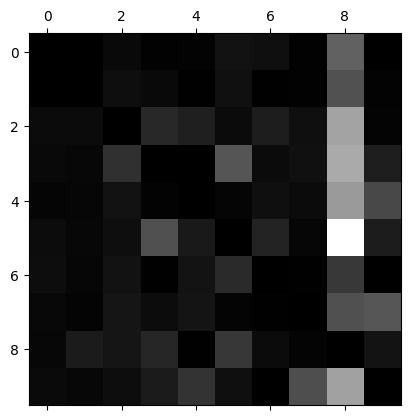

In [55]:
# 주 대각선만 0으로 채워 그래프 그리기(다른 항목 유지)
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

- 행 : 실제 클래스 / 열 : 예측 클래스
- 8열이 밝으므로 많은 이미지가 8로 잘못 분류되었음을 암시한다.
- 8행은 나쁘지 않음 -> 오타 행렬은 반드시 대칭인 것은 아니다.
- 오차 행렬을 분석하면 분류기 성능 향상 방안에 대한 통찰을 얻을 수 있다.

In [56]:
# 맷플롯립의 imshow() 사용하는 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

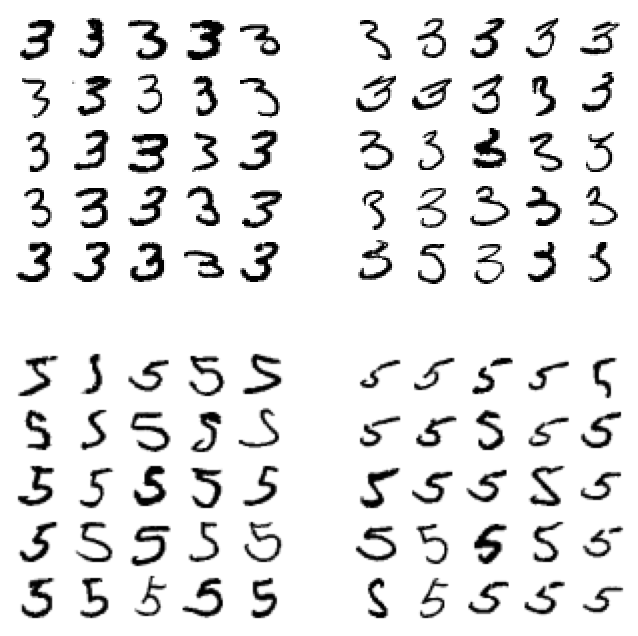

In [57]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

- 이미지를 중앙에 위치시키고 회전되지 않도록 전처리 한다면 에러가 줄어들 것이다.

---
## 3.6 다중 레이블 분류

다중 레이블 분류 시스템: 여러 개의 이진 꼬리표를 출력하는 분류 시스템

In [58]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

- 각 숫자 이미지에 두 개의 타킷 레이블이 담긴 y_multilabel 배열 만들기
- 첫 번째는 순자가 큰 값(7,8,9)인지를, 두 번째는 홀수인지 나타냄.

In [59]:
# 예측을 만들면 두 개의 레이블 출력
knn_clf.predict([some_digit])

array([[False,  True]])

- 올바르게 분류됨(숫자 5는 크지 않고(False), 홀수(True))

In [60]:
# 다중 레이블 분류기 평가
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
print(f1_score(y_multilabel, y_train_knn_pred, average="macro"))

0.976410265560605


- 모든 레이블에 대한 F1 점수의 평균 계산

---
## 3.7 다중 출력 분류

다중 출력 다중 클래스 분류(다중 출력 분류): 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것. (값을 두 개 이상 가질 수 있음).

In [61]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

- randint() 함수를 사용하여 픽셀 강도에 잡음 추가

In [62]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = plt.cm.binary,
               interpolation="nearest")
    plt.axis("off")

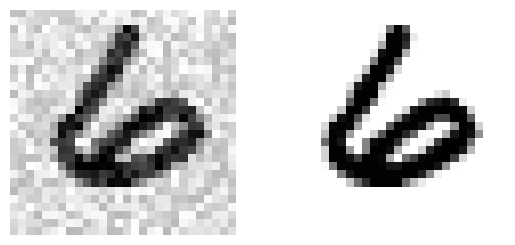

In [63]:
# 테스트 세트에서 이미지 하나 선택
some_index = 5501
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

- 왼쪽이 잡음 섞인 이미지, 오른쪽이 깨끗한 타깃 이미지


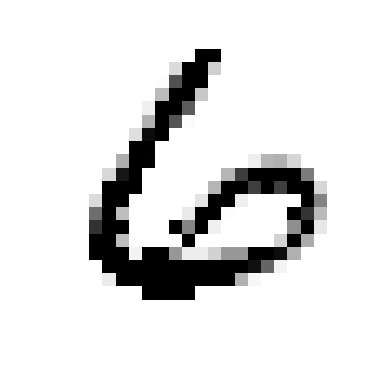

In [64]:
# 분류기를 훈련시켜 이 이미지를 깨끗하게 만들어보기
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

- 타깃과 비슷하다.